<div class="alert alert-warning">
После установки библиотеки natasha необходимо заменить файл addr.py (\natasha\grammars) для корректной работы данного проекта.
</div>

# Определение топонимов в текстах комментариев социальной сети

**Заказчик** - Pollen.club - краудсорсинговый сервис, призванный помочь в управлении симптомами пыльцевой аллергии и объединяющий тысячи людей. Через сайт и мобильное приложение «Пыльца Club» аллергики ежедневно получают информацию об опасной алергенной пыльце в воздухе и рисках, которые подстерегают их во внешней среде.  

**Цель**  - разработка решения для автоматического выделения топонимов (конкретно - названий городов и областей) в сообщениях, которые пишут участники сообщества. Дополнительно были выделены аллергены, симптомы и названия лекарств, упоминаемые участниками в сообщениях.

**Входные данные:** файл .txt в следующем виде:


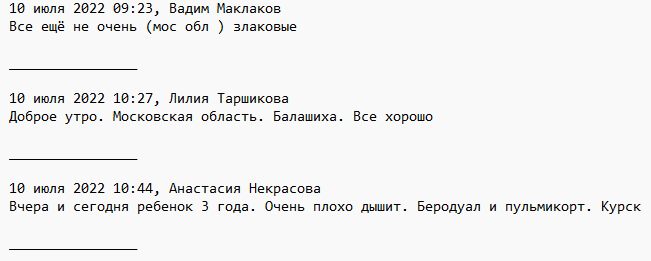

In [2]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
from natasha import AddrExtractor
from tqdm import tqdm
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
import sklearn
from sklearn.metrics import f1_score
import re
from random import sample 
from random import seed

import json
from ipymarkup import show_span_ascii_markup as show_markup
from yargy import (
    Parser,
    rule, or_, and_, not_
)
from yargy.predicates import (
    eq, in_, gram,
    type, normalized,
    dictionary,
    gte, lte
)
from yargy.pipelines import (
    pipeline,
    morph_pipeline
)
from yargy.interpretation import (
    fact,
    attribute
)
from yargy.tokenizer import MorphTokenizer, EOL
NOUN = gram('NOUN')
ADJF = gram('ADJF')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 370)

In [3]:
# открываем файл
with open('C:/Users/user/Desktop/Проекты/projects/Аллергия/Эля/text.txt', 'r', encoding='utf-8') as f:
    unsplited = f.read()

In [4]:
# преобразовываем данные в датафрейм, разбивая на разные столбцы части сообщения
unsplited = unsplited.split('\n--------------------------\n')
listed_data = [] #будущий список сообщений
#
tmp_msg = ''    #временная переменная для сообщения
tmp_user = ''   #временная переменная для имени пользователя
tmp_date = ''   #временная переменная для даты
quota = 0       #переменная для хранения индекса запятой
#разбиваем строку с сообщениями на список отдельных сообщений
splited = unsplited[-1].split('\n\n________________\n\n')
#цикл поиска запятой и символа \n
for item in splited:
    for i in range(len(item)):
        #запомним индекс запятой
        if item[i] == ',':
            quota = i
        #найдем первый \n
        if item[i] == '\n':
            #подстрока с сообщением. от символа \n до конца строки
            tmp_msg = item[(i+1):].strip()
            if tmp_msg.find(']') != -1:
                tmp_msg = tmp_msg[(tmp_msg.find(']')+3):]
            #подстрока с датой от начала до запятой
            tmp_date = item[:(quota)]
            #подстрока с именем пользователя от запятой до \n
            tmp_user = item[(quota+1):(i-1)]
            #заканчиваем цикл досрочно
            break
    #делаем список [tmp_date, tmp_user, tmp_msg] и закидиваем в списое сообщений
    listed_data.append([tmp_date, tmp_user, tmp_msg])
    #не обязательно, но мне кажется так лучше, что бы случайностей не было
    tmp_msg = ''
    tmp_user = ''
    tmp_date = ''
    quota = 0
#из списка делаем датафрейм
df = pd.DataFrame(listed_data, columns = ['date', 'user', 'msg'])

In [5]:
df.head()

,date,user,msg
0,﻿10 июля 2022 09:23,Вадим Маклако,Все ещё не очень (мос обл ) злаковые
1,10 июля 2022 10:27,Лилия Таршиков,Доброе утро. Московская область. Балашиха. Все хорошо
2,10 июля 2022 10:44,Анастасия Некрасов,Вчера и сегодня ребенок 3 года. Очень плохо дышит. Беродуал и пульмикорт. Курск
3,10 июля 2022 11:04,Яна Николаенк,Что у вас сейчас пылит? Полынь не началась?
4,10 июля 2022 14:08,Анастасия Некрасов,Вроде нет


In [6]:
# используем регулярные выражения для определения наиболее популярных сокращений названий городов:

# "мо, мос обл, мос.обл." в любом регистре теперь будет определяться как "Московская область"
df['msg'] = df['msg'].map(lambda x: re.sub(r"\bмо\b|\bмос обл\b|bмос.обл.\b", "Московская область", x, flags=re.I))

# районы Москвы определяются как "Москва"
df['msg'] = df['msg'].map(lambda x: re.sub(
    r'(ЦАО)|(САО)|(СВАО)|(ВАО)|(ЮВАО)|(ЮАО)|(ЮЗАО)|(ЗАО)|(СЗАО)|(НАО)|(ТиНАО)', "Москва", x, flags=re.I))

# "питер" определяется как "Санкт-Петербург"
df['msg'] = df['msg'].map(lambda x: re.sub(r"\bпитер[а|о|е]?[м]?\b", "Санкт-Петербург", x, flags=re.I))

# "Екатеринбург"
df['msg'] = df['msg'].map(lambda x: re.sub(r"\bекб\b|bЕ-бург\b|bебург\b|bект\b|bЕкат\b", "Екатеринбург", x, flags=re.I))

# "Новороссийск"
df['msg'] = df['msg'].map(lambda x: re.sub(r"\bноворос\b", "Новороссийск", x, flags=re.I))

# "Владивосток"
df['msg'] = df['msg'].map(lambda x: re.sub(r"\bвладик\b", "Владивосток", x, flags=re.I))

# "Новосибирск"
df['msg'] = df['msg'].map(lambda x: re.sub(r"\bнсиб\b|bновосиб\b", "Новосибирск", x, flags=re.I))

# "Зеленоград"
df['msg'] = df['msg'].map(lambda x: re.sub(r"\bзелек\b|bзелик\b", "Зеленоград", x, flags=re.I))

# "Нижний Новгород"
df['msg'] = df['msg'].map(lambda x: re.sub(r"\bнино\b", "Нижний Новгород", x, flags=re.I))

# "Ростов-на-Дону"
df['msg'] = df['msg'].map(lambda x: re.sub(r"\bрдн\b", "Ростов-на-Дону", x, flags=re.I))

In [7]:
df = df.drop_duplicates()
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


In [8]:
# функция, выделяющая локации
def name_recognize_natasha(text):
    global morph
    extractor = AddrExtractor(morph)
    matches = extractor(text)
    if matches != None:
        result = ''
        for index, match in enumerate(matches):
            if match != None:
                result += str(match.fact) 
    if result !='':
        return result
    else:
        return 0

In [9]:
# ограничим наш список сообщений 1000 (из 16 250). При дальнейшем использовании, эту строку следует закоментить
df = df[0:1000]

In [10]:
# используем такой подход к созданию 2-х новых столбцов для видимости времени выполнения. Данную ячейку можно выполнить без цикла
# df['LOC'] - определение названия локации, df['NATASHA_mark'] - оценка есть ли локация (1) или нет локации (0) - нужен для метрики
for i in tqdm(range(0, 1)):
    df['LOC'] = df.msg.apply(name_recognize_natasha)
    
    df['NATASHA_mark'] = df.LOC.apply(lambda x: x if x==0 else 1 )

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:39<00:00, 99.54s/it]


In [11]:
# выделение русских слов из работы функции определения локаций
ru = re.compile('[а-яА-Яё]+')

for i in range(len(df.index)):
    h = ru.findall(str(df['LOC'].iloc[i]))
    df['LOC'].iloc[i] = ' '.join(h)

C:\Users\user\AppData\Local\Temp\ipykernel_9056\3167698422.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LOC'].iloc[i] = ' '.join(h)


In [12]:
# Создадим функцию, которая извлечет слова по созданным нами правилам
def show_matches(rule, *lines):
    parser = Parser(rule)
    for line in lines:
        matches = parser.findall(line)
        spans = [_.span for _ in matches]
        show_markup(line, spans)

In [13]:
# Загрузим данные по лекарствам, симптомам и аллергенам (из заранее приготовленных файлов)
def load_lines(path):
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            yield line.rstrip('\n').strip()
ALLERGY_ = set(load_lines('allergy_dict.txt'))
PILLS_ = set(load_lines('pills_dict.txt'))
SYMP = set(load_lines('symptoms.txt'))
#seed(10)
#sample(sorted(ALLERGY_), 10), sample(sorted(PILLS_), 10), sample(sorted(SYMP), 10)

In [14]:
# Создадим правила для поиска лекарств и аллергенов, симптомов в тексте
Allergens = fact('Allergens', ['name'])
Pills = fact('Pills', ['name'])
Symptoms = fact('Symptoms', ['name'])
ALLERGY = morph_pipeline(ALLERGY_).interpretation(Allergens.name.normalized())
PILLS = morph_pipeline(PILLS_).interpretation(Pills.name.normalized())
SYMPT_ = morph_pipeline(SYMP).interpretation(Symptoms.name.normalized())
ALLERGENS = rule(ALLERGY).interpretation(Allergens)
_PILLS_ = rule(PILLS).interpretation(Pills)
SYMPTOMS = rule(SYMPT_).interpretation(Symptoms)

In [15]:
# Создадим столбцы для аллергенов, симптомов и лекарств
parser = Parser(ALLERGENS)
df['allergen'] = df.msg.apply(lambda x: ', '.join([match.fact.name for match in parser.findall(x)]))
parser = Parser(_PILLS_)
df['pills_l'] = df.msg.apply(lambda x: ', '.join([match.fact.name for match in parser.findall(x)]))
parser = Parser(SYMPTOMS)
df['symptoms_l'] = df.msg.apply(lambda x: ', '.join([match.fact.name for match in parser.findall(x)]))

In [16]:
# df_all - все сообщения, независимо содержат ли они искомые сущности или нет
df_all = df.copy()
df_all = df_all.drop(columns=['NATASHA_mark'], axis=1)
df_all.head(10)

,date,user,msg,LOC,allergen,pills_l,symptoms_l
0,﻿10 июля 2022 09:23,Вадим Маклако,Все ещё не очень (Московская область ) злаковые,Московская область,,,
1,10 июля 2022 10:27,Лилия Таршиков,Доброе утро. Московская область. Балашиха. Все хорошо,Московская область Балашиха,,,
2,10 июля 2022 10:44,Анастасия Некрасов,Вчера и сегодня ребенок 3 года. Очень плохо дышит. Беродуал и пульмикорт. Курск,Курск,,"Беродуал, Пульмикорт",
3,10 июля 2022 11:04,Яна Николаенк,Что у вас сейчас пылит? Полынь не началась?,,Полынь,,
4,10 июля 2022 14:08,Анастасия Некрасов,Вроде нет,,,,
5,10 июля 2022 14:39,Мария Сафронов,"Добрый день. Самочувствие плохое, очень сильный насморк весь день (Москва)",Москва,,,
6,10 июля 2022 14:43,Гарольд Бран,"Москва, проснулся с кашлем и хрипами, запил АГ, заснул дальше.",Москва,,,Хрипы
7,9 июля 2022 08:56,Виктор Беляе,Мытищи. Почти нормально.,Мытищи,,,
8,9 июля 2022 10:57,Дина Шарипов,СПб. Чихание и небольшой отек в носу. Аллергия на берёзу и полынь. А теперь и не знаю на что!,Санкт Петербург,"Береза, Полынь",,"Чихание, отеки, аллергия"
9,9 июля 2022 12:33,Анастасия Камынин,Спб. Ребёнок без АГ пару дней. Самочувствие хорошее 👍,Санкт Петербург,,,


**Вывод только тех сообщений, где есть локация, информация об аллергене, лекарстве или симптоме**

In [17]:
df_info = df_all.query('LOC != "" | allergen != "" | pills_l != "" | symptoms_l != ""')

In [18]:
df_info.head(10)

,date,user,msg,LOC,allergen,pills_l,symptoms_l
0,﻿10 июля 2022 09:23,Вадим Маклако,Все ещё не очень (Московская область ) злаковые,Московская область,,,
1,10 июля 2022 10:27,Лилия Таршиков,Доброе утро. Московская область. Балашиха. Все хорошо,Московская область Балашиха,,,
2,10 июля 2022 10:44,Анастасия Некрасов,Вчера и сегодня ребенок 3 года. Очень плохо дышит. Беродуал и пульмикорт. Курск,Курск,,"Беродуал, Пульмикорт",
3,10 июля 2022 11:04,Яна Николаенк,Что у вас сейчас пылит? Полынь не началась?,,Полынь,,
5,10 июля 2022 14:39,Мария Сафронов,"Добрый день. Самочувствие плохое, очень сильный насморк весь день (Москва)",Москва,,,
6,10 июля 2022 14:43,Гарольд Бран,"Москва, проснулся с кашлем и хрипами, запил АГ, заснул дальше.",Москва,,,Хрипы
7,9 июля 2022 08:56,Виктор Беляе,Мытищи. Почти нормально.,Мытищи,,,
8,9 июля 2022 10:57,Дина Шарипов,СПб. Чихание и небольшой отек в носу. Аллергия на берёзу и полынь. А теперь и не знаю на что!,Санкт Петербург,"Береза, Полынь",,"Чихание, отеки, аллергия"
9,9 июля 2022 12:33,Анастасия Камынин,Спб. Ребёнок без АГ пару дней. Самочувствие хорошее 👍,Санкт Петербург,,,
12,9 июля 2022 14:50,Ирина Гусынкин,"Вчера днём покосила на даче в очках, маске naroo. Вечером першение в горле, кашель при попытке лечь спать (правда ела ещё кукурузную кашу, может она тоже сказалась). Зиртек снял симптомы 👌",,,Зиртек,


Посчитаем точность и полноту определения локаций:

In [19]:
# выгружаем данные для создания разметки

writer = pd.ExcelWriter('all_comment.xlsx')
df.to_excel(writer)
writer.save()
print('DataFrame is written successfully to Excel File.')

DataFrame is written successfully to Excel File.


In [21]:
# открываем размеченный файл. "mark" - ручная отметка
df_met = pd.read_excel('C:/Users/user/Desktop/Проекты/projects/Аллергия/GitHub/разметка для FIN.xlsx')

In [22]:
df_met = df_met.drop(columns=['Unnamed: 0'], axis=1)
df_met.head(10)

,date,user,msg,LOC,NATASHA_mark,mark
0,﻿10 июля 2022 09:23,Вадим Маклако,Все ещё не очень Московская область злаковые,Московская область,1,1
1,10 июля 2022 10:27,Лилия Таршиков,Доброе утро. Московская область. Балашиха. Все хорошо,Московская область Балашиха,1,1
2,10 июля 2022 10:44,Анастасия Некрасов,Вчера и сегодня ребенок года. Очень плохо дышит. Беродуал и пульмикорт. Курск,Курск,1,1
3,10 июля 2022 11:04,Яна Николаенк,Что у вас сейчас пылит Полынь не началась,NaN,0,0
4,10 июля 2022 14:08,Анастасия Некрасов,Вроде нет,NaN,0,0
5,10 июля 2022 14:39,Мария Сафронов,"Добрый день. Самочувствие плохое, очень сильный насморк весь день Москва",Москва,1,1
6,10 июля 2022 14:43,Гарольд Бран,"Москва, проснулся с кашлем и хрипами, запил АГ, заснул дальше.",Москва,1,1
7,9 июля 2022 08:56,Виктор Беляе,Мытищи. Почти нормально.,Мытищи,1,1
8,9 июля 2022 10:57,Дина Шарипов,СПб. Чихание и небольшой отек в носу. Аллергия на берёзу и полынь. А теперь и не знаю на что,Санкт Петербург,1,1
9,9 июля 2022 12:33,Анастасия Камынин,Спб. Ребёнок без АГ пару дней. Самочувствие хорошее,Санкт Петербург,1,1


In [23]:
df_met['mark'] = pd.to_numeric(df_met['mark'], downcast='integer')
df = df[0:999]

In [24]:
F1 = f1_score(df_met.mark, df.NATASHA_mark)
print(f'F1-мера составила {F1:.1%}')

F1-мера составила 99.1%


In [25]:
precision = sklearn.metrics.precision_score(df_met.mark, df.NATASHA_mark)
print(f'Точность определения локаций составила {precision:.1%}')

Точность определения локаций составила 98.8%


In [26]:
recall = sklearn.metrics.recall_score(df_met.mark, df.NATASHA_mark)
print(f'Полнота определения локаций составила {recall:.1%}')

Полнота определения локаций составила 99.5%


**Доработав библиотеку Natasha удалось на реальных данных (текстовые сообщения пользователей в социальной сети) добиться точности и полноты определения локаций в 99%.**

P.S.

Посмотрим на те сообщения из 1000, которые отработаны неверно:

In [27]:
data_loc_1 = df_met[df_met['mark'] == 1] 
data_loc_2 = data_loc_1[data_loc_1['NATASHA_mark'] == 0]
data_loc_2

,date,user,msg,LOC,NATASHA_mark,mark
318,24 июня 2022 07:36,Ольга Михайлов,"Мос.обл. Нос, чих, горло чешется. Такого года у меня не было НИКОГДА. Что же творится",NaN,0,1
611,14 июня 2022 08:41,Лариса Царьков,"за Юрьев Польским вчера встретила цветущую тимофеевку. Вот вот, видимо",NaN,0,1


In [28]:
data_loc_3 = df_met[df_met['mark'] == 0] 
data_loc_4 = data_loc_3[data_loc_3['NATASHA_mark'] == 1]
data_loc_4

,date,user,msg,LOC,NATASHA_mark,mark
425,19 июня 2022 10:58,Southern Win,"Вчера прошлась в другой район по полю у нас тут реально заросли травы вдоль ж д не косят , в итоге насморк сильный. Хотя на сорные травы мне брали анализ, реакции не было.",NaN,1,0
542,15 июня 2022 12:43,Галина Агеев,"у него аллергия была всегда в июле. В этом году гораздо раньше началась, как и друзей. Вылезла перекрёстная на клубнику и чеснок. Плюс у друзей нет на луговые. И в других частях города всем лучше. А у нас в районе всем не ок. Рядом сосновый Бор. Поэтому сосны у нас под подозрением, тем более что они цвести начинают только когда температура выше .",NaN,1,0
648,11 июня 2022 12:33,Артём Антипо,"Орешник и Ольха цветут обильно. Обычно в самом начале года. Удивительно, но симптомы не ловили. Сами березовики, на местные раннецветущие реагируем в полный рост.",Рост,1,0
738,8 июня 2022 08:20,Любовь Якин,"С утром. У сына опять чешутся глазки, заложенность на ночь, чех. Легче конечно, но приятного мало.",Чех,1,0
804,7 июня 2022 10:22,Александр Сергее,"да вопрос не района, а на что у вас аллергия,моя история это береза, а щас и травки цветут и все остальное",NaN,1,0
